In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpeq357r/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpeq357r/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp6f8ycy/6174b19f8005a60d6a2faaae7ff1c9a7.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp6f8ycy/6174b19f8005a60d6a2faaae7ff1c9a7.exp



In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((100,64*64))
trX=trX/255
trX[trX>=0.5]=1
trX[trX<=0.5]=0
data1=trX
%matplotlib inline
for i in range(100):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    temp[temp>=0.5]=1
    temp[temp<=0.5]=0
    data2[i,:]=temp.reshape(-1)

In [5]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

# def batchnorm( x, g=None, b=None, eps=1e-8 ):
#     if x.ndim == 4:
#         m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
#         v = tensor.mean(tensor.sqr(x - m), 
#                           axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

#         x = (x - m) / tensor.sqrt( v + eps )
#         if g is not None and b is not None:
#             x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

#     elif x.ndim == 2:
#         m = tensor.mean(x, axis=0)
#         v = tensor.mean(tensor.sqr(x - m), axis=0)

#         x = (x - m) / tensor.sqrt( v + eps )
#         if g is not None and b is not None:
#             x = x*g + b

#     return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [6]:
import sys
sys.path.append('..')

import os
import json
import scipy.io
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import math
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import conv_cond_concat, deconv, dropout, batchnorm
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score
np.set_printoptions(threshold='nan')
#from load import mnist_with_valid_set

#trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#image = scipy.io.loadmat('WB_test64_GAN.mat')
#data1=np.abs(image['WB_test64_GAN']-1)

vaX= data2[0:100]
trX= data2[0:100]
#vaX= data2
#trX= data2
vaX = floatX(vaX)

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
#ny = 10           # # of classes
nbatch = 10      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 30          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 20          # # of gen filters in first conv layer
ndf = 20          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 10000       # # of iter at starting learning rate
niter_decay = 0 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
#ntrain, nval, ntest = len(trX), len(vaX), len(teX)
#ntrain = len(trX)

def transform(X):
    return (floatX(X)).reshape(-1, nc, npx, npx)
    #return (floatX(X)).reshape(-1, nc, npx, npx)
def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()

bce = T.nnet.binary_crossentropy
tanh = activations.Tanh()

eifn = inits.Normal(scale=0.02)
gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

#generator
gwf = gifn((nz, ngfc), 'gwf')
ggf = gain_ifn((ngfc), 'ggf')
gbf = bias_ifn((ngfc), 'gbf')

gw = gifn((ngfc, ngf*4*8*8), 'gw')
gg = gain_ifn((ngf*4*8*8), 'gg')
gb = bias_ifn((ngf*4*8*8), 'gb')
#gw2 = gifn((ngf*8, ngf*4, 5, 5), 'gw2')
#gg2 = gain_ifn((ngf*4), 'gg2')
#gb2 = bias_ifn((ngf*4), 'gb2')
gw3 = gifn((ngf*4, ngf*2, 5, 5), 'gw3')
gg3 = gain_ifn((ngf*2), 'gg3')
gb3 = bias_ifn((ngf*2), 'gb3')
gw4 = gifn((ngf*2, ngf, 5, 5), 'gw4')
gg4 = gain_ifn((ngf), 'gg4')
gb4 = bias_ifn((ngf), 'gb4')
gwx = gifn((ngf, nc, 5, 5), 'gwx')

#discriminator
dw  = difn((ndf, nc, 5, 5), 'dw')
dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')
dw3 = difn((ndf*4, ndf*2, 5, 5), 'dw3')
dg3 = gain_ifn((ndf*4), 'dg3')
db3 = bias_ifn((ndf*4), 'db3')
# dw4 = difn((ndf*8, ndf*4, 5, 5), 'dw4')
# dg4 = gain_ifn((ndf*8), 'dg4')
# db4 = bias_ifn((ndf*8), 'db4')
dw5 = difn((ndf*4*8*8, ndfc), 'dw5')
dwy = difn((ndfc, 1), 'dwy')

# gen_params = [gw, gwf, ggf, gbf, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gw4, gg4, gb4, gwx]
# discrim_params = [dw, dw2, dg2, db2, dw3, dg3, db3, dw4, dw5, dg4, db4, dwy]

gen_params = [gw, gwf, ggf, gbf, gg, gb, gw3, gg3, gb3, gw4, gg4, gb4, gwx]
discrim_params = [dw, dw2, dg2, db2, dw3, dg3, db3, dw5, dwy]

# def gen(Z, w, wf, gf, bf, g, b, w2, g2, b2, w3, g3, b3, w4, g4, b4, wx):
def gen(Z, w, wf, gf, bf, g, b, w3, g3, b3, w4, g4, b4, wx):
    h0 = relu(batchnorm(T.dot(Z, wf), g=gf, b=bf))
    h = relu(batchnorm(T.dot(h0, w), g=g, b=b))
    h = h.reshape((h.shape[0], ngf*4, 8, 8))
    #h2 = relu(batchnorm(deconv(h, w2, subsample=(2, 2), border_mode=(2, 2)), g=g2, b=b2))
    h3 = relu(batchnorm(deconv(h, w3, subsample=(2, 2), border_mode=(2, 2)), g=g3, b=b3))
    h4 = relu(batchnorm(deconv(h3, w4, subsample=(2, 2), border_mode=(2, 2)), g=g4, b=b4))
    x = sigmoid(deconv(h4, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

#def discrim(X, w, w2, g2, b2, w3, g3, b3, w4, w5, g4, b4, wy):
def discrim(X, w, w2, g2, b2, w3, g3, b3, w5, wy):    
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)), g=g2, b=b2))
    h3 = lrelu(batchnorm(dnn_conv(h2, w3, subsample=(2, 2), border_mode=(2, 2)), g=g3, b=b3))
    #h4 = lrelu(batchnorm(dnn_conv(h3, w4, subsample=(2, 2), border_mode=(2, 2)), g=g4, b=b4))
    h4 = T.flatten(h3, 2)
    h5 = lrelu(batchnorm(T.dot(h4, w5)))
    y = sigmoid(T.dot(h5, wy))
    return y

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
#updates = d_updates + g_updates

print 'COMPILING......'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)


#sample_zmb = floatX(np_rng.uniform(-1., 1., size=(nvis, nz)))

vaX = vaX.reshape(len(vaX), -1)    

n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
vae_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
print 'start training......'


DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpfm_ppa/da6ac6908198a9d83223e8a2be6b76b9.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpfm_ppa/da6ac6908198a9d83223e8a2be6b76b9.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpdcbvmv/316e2e1cbfbe8cfb8e4a101f329ffeec.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpdcbvmv/316e2e1cbfbe8cfb8e4a101f329ffeec.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-

COMPILING......


DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp0g9dob/df759d5ffdd8d77ea62872864812b8f7.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp0g9dob/df759d5ffdd8d77ea62872864812b8f7.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpxda0dz/939b4d4030726d7af244af4a72d0f7da.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpxda0dz/939b4d4030726d7af244af4a72d0f7da.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-

848.69 seconds to compile theano functions
start training......


DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp58r3no/a58682ae410f192efa2fa4665860f0c2.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp58r3no/a58682ae410f192efa2fa4665860f0c2.exp



In [7]:
for epoch in range(1,2*niter):
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    if (epoch) % 10 == 0:
        print '%.0f %.4f %.4f'%(epoch, g_cost, d_cost)
#     if n_epochs > niter:
#         lrt.set_value(floatX(lrt.get_value() - lr/niter_decay))

10 1.0057 1.0200
20 1.2057 0.8303
30 1.3881 0.7090
40 1.6175 0.6312
50 1.7295 0.6000
60 1.9218 0.3973
70 2.2218 0.3771
80 2.1004 0.6339
90 2.3010 0.3400
100 2.4677 0.2337
110 2.5745 0.2029
120 2.7044 0.2263
130 2.8231 0.1688
140 2.9418 0.1427
150 3.0106 0.2369
160 2.2269 0.3266
170 2.9408 0.1477
180 3.0285 0.1211
190 3.0522 0.1207
200 3.1516 0.1048
210 3.2257 0.1260
220 3.0484 0.1317
230 3.3790 0.1821
240 2.0304 0.2050
250 2.9648 0.0994
260 3.3268 0.1435
270 3.2561 0.0819
280 3.0090 0.0886
290 3.6590 0.1548
300 3.2264 0.0858
310 3.5157 0.0612
320 3.3038 0.0680
330 3.2533 0.0882
340 3.3743 0.0794
350 3.3460 0.0672
360 4.5510 0.0457
370 3.4321 0.0718
380 3.4679 0.0610
390 3.8688 0.0646
400 4.3397 0.0513
410 3.5704 0.0515
420 3.7845 0.0519
430 1.7031 2.7993
440 2.4285 0.2805
450 3.2670 0.0881
460 3.7271 0.0751
470 4.2433 0.1342
480 3.3921 0.0586
490 3.4733 0.0536
500 3.6833 0.0594
510 3.8863 0.0834
520 5.3663 0.0292
530 3.7957 0.0424
540 4.2993 0.0860
550 3.8790 0.0368
560 4.2944 0.0296
5

In [240]:
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))
samples = np.asarray(_gen(sample_zmb))
grayscale_grid_vis(inverse_transform(samples), (10, 20), 'samplesXX/%s/%d.png'%(desc, n_epochs))

NameError: name 'desc' is not defined

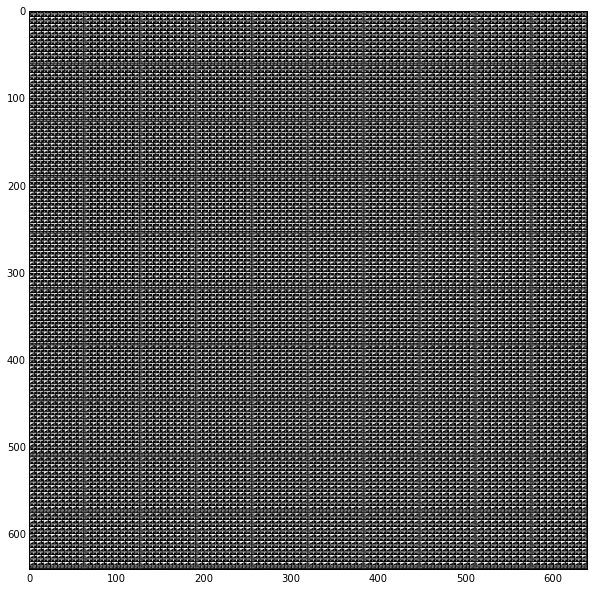

In [8]:
n = 10  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()